In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
import math
import torch
import matplotlib.pyplot as plt

# install instructions here https://github.com/nicola-decao/power_spherical
from power_spherical import PowerSpherical

In [3]:
torch.manual_seed(0)

In [4]:
# here we create a PowerSpherical distribution with n_clusters locations around the unit circle
# see here for more info (https://arxiv.org/abs/2006.04437). TLDR: the PowerSpherical distribution 
# needs a directiona and a scale parameter and it has support on the n-sphere
n_clusters = 6

dist = PowerSpherical(
    loc=torch.tensor([
      [
          math.cos(2 * torch.pi * i / n_clusters),
          math.sin(2 * torch.pi * i / n_clusters)
      ]
      for i in range(n_clusters)
    ]),
    scale=torch.tensor([500. for _ in range(n_clusters)]),
)

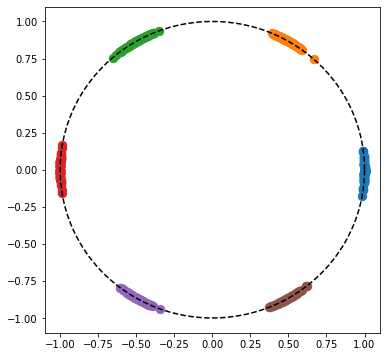

In [5]:
# here we sample from the distributions and we plot it
plt.figure(figsize=(6, 6))
t = torch.linspace(0, 2 * torch.pi, 1000)
plt.plot(torch.cos(t), torch.sin(t), "--", color="black")

n_samples = 100
samples = dist.sample((n_samples,))
for e in samples.transpose(0, 1):
    plt.scatter(*e.T, s=70)
plt.show()

In [6]:
# creates a random projection of dimensionality dim and adds gaussian noise
def random_proj(x, dim=10, noise=0.05):
    with torch.no_grad():
        x = torch.cat((x, torch.randn(x.shape[:-1] + (dim - x.shape[-1],)) * noise), dim=-1)
        x /= x.norm(dim=-1, keepdim=True)
        f = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(dim, dim, bias=False))
        return f(x)

projected_samples = random_proj(samples).flatten(0, 1)

In [7]:
# lets how well we can reconstruct with k_components
svd = projected_samples.svd()
k_components = 2
svd.U * (svd.S * (svd.S >= svd.S.topk(k_components).values[-1]).float()) @ svd.V.T, projected_samples

(tensor([[-0.0288, -0.4631, -0.0234,  ...,  0.1320, -0.5859, -0.3396],
         [-0.4427, -0.0247, -0.2186,  ...,  0.4573, -0.1007, -0.3798],
         [-0.3981,  0.4345, -0.1874,  ...,  0.3100,  0.4828, -0.0300],
         ...,
         [ 0.0009,  0.4757,  0.0099,  ..., -0.1064,  0.5973,  0.3253],
         [ 0.4567, -0.0053,  0.2248,  ..., -0.4649,  0.0653,  0.3709],
         [ 0.4113, -0.4230,  0.1942,  ..., -0.3260, -0.4663,  0.0486]]),
 tensor([[-0.0906, -0.4414, -0.0625,  ...,  0.1554, -0.6123, -0.3435],
         [-0.4741, -0.0607, -0.3550,  ...,  0.4510, -0.1348, -0.3531],
         [-0.4207,  0.4263, -0.1839,  ...,  0.3351,  0.5416, -0.0322],
         ...,
         [-0.0308,  0.4496, -0.0033,  ..., -0.0755,  0.6370,  0.3022],
         [ 0.4811,  0.0545,  0.2207,  ..., -0.5071,  0.0323,  0.4255],
         [ 0.4372, -0.4146,  0.1711,  ..., -0.3379, -0.5009,  0.0178]]))

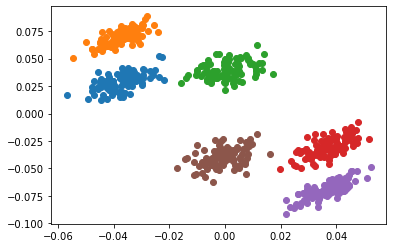

In [8]:
# let's plot PCA with 2 dim. since the original dimensionality of the data is 2 we can notice that 
# clusters appear very clearly and they are also separable
for e in projected_samples.view(n_samples, n_clusters, -1).transpose(0, 1):
    plt.scatter(*(e @ svd.U[:2].T).T)
plt.show()

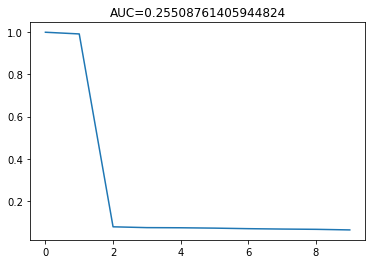

In [9]:
# AUC plot
normalized_eigenvalues = svd.S / svd.S.max()
plt.title(f"AUC={normalized_eigenvalues.mean()}")
plt.plot(normalized_eigenvalues)
plt.show()